# classify_review_ratings

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestCentroid
from sklearn.utils.extmath import density
from sklearn import metrics
from scipy.stats import pearsonr
import pandas as pd
import connect_aws_db as cadb


In [2]:
%matplotlib inline

In [53]:
engine = cadb.connect_aws_db(write_unicode=True)

### Restore BF Reviews and Ratings to Train Model

In [4]:
cmd = "SELECT review_rating, review_text FROM bf_reviews"

In [5]:
bfdf = pd.read_sql_query(cmd, engine)

In [6]:
print(len(bfdf))
bfdf.head(5)

3150


,review_rating,review_text
0,2,When you first go to your room you notice the ...
1,2,We were going to the Pre-Westminster event tha...
2,2,While the room was not the fanciest that one c...
3,1,I stayed at the Hotel Penn in Manhattan becaus...
4,5,We loved this hotel! The are very friendly and...


In [7]:
bfdfl = bfdf[bfdf['review_text'].str.len() > 300].copy()

In [8]:
len(bfdfl)

1508

### Create Training Data

In [9]:
train_data = bfdfl['review_text'].values

In [10]:
y_train = bfdfl['review_rating'].values

In [11]:
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                             stop_words='english')
X_train = vectorizer.fit_transform(train_data)
duration = time() - t0
print('vectorized in {:.2f} seconds.'.format(duration))
print(X_train.shape)

vectorized in 0.18 seconds.
(1508, 7458)


### Restore the Yelp Data to Classify

In [17]:
cmd = "SELECT * FROM yelp_reviews WHERE review_category = 'dog'"

In [18]:
yelpdf = pd.read_sql_query(cmd, engine)

In [19]:
print(len(yelpdf))
yelpdf.head(5)

483


,rev_id,business_id,yelp_review_date,yelp_review_id,review_rating,review_text,user_id,review_category
0,110,4dwdYuD4vEBByfVQ--vlVw,2013-01-08,tgDfMZ2dhTYl_RScNiIogw,5,Stay here often for work - hotel is pet friend...,QswzyHSZ0hz_ZblfwugQ6g,dog
1,165,FQudBiBiz9bGQLF_kK8UCg,2013-05-29,F7l3La3FH0VZDgKwV3lz0A,1,Nice Staff but that's about all. Would never s...,W6t6UlWYGAx2jrYb-dxo8A,dog
2,231,6Ckmrpp6OW1pJ-3Pjg7VaQ,2013-10-17,a7jzORIdqTO9kmKYhHVebQ,2,So we had to switch rooms 2 times before we ha...,ZPFLi-ucmuaHlR4oow7XYg,dog
3,237,6Ckmrpp6OW1pJ-3Pjg7VaQ,2014-09-10,WBUxaxAyDOVYxZZfKg0QnQ,3,You get what you pay for. Overall a clean hote...,0rwDvNyDvin8C8eZxmZ1Wg,dog
4,654,eAuZtSnA6cgwR7Um7eA2rg,2013-04-16,PXQFXHdHLQNP-2gWCfAYzw,5,"When I first contacted the Windmill Inn, the r...",2I1tE5FLIHC-jhyPwMIHig,dog


In [21]:
yelp_review_text = yelpdf['review_text'].values

In [29]:
len(yelpdf)

483

In [31]:
len(np.unique(yelpdf['business_id']))

74

### Create Data Set to Predict

In [22]:
t0 = time()
X_pred = vectorizer.transform(yelp_review_text)
duration = time() - t0
print('transformed test data in {:.2f} seconds.'.format(duration))

transformed test data in 0.04 seconds.


### Create and Train Model

In [21]:
clf = NearestCentroid()
print(clf)

NearestCentroid(metric='euclidean', shrink_threshold=None)


In [22]:
clf.fit(X_train, y_train)

NearestCentroid(metric='euclidean', shrink_threshold=None)

### Predict Yelp Reviews

In [25]:
y_pred = clf.predict(X_pred)

In [26]:
y_pred.shape

(483,)

In [27]:
y_pred[:10]

array([5, 4, 5, 4, 5, 4, 2, 4, 5, 5])

In [28]:
yelpdf['dog_review'] = y_pred

### Restore the TA data to classify

In [15]:
cmd = "SELECT * FROM ta_reviews WHERE review_category = 'dog'"

In [16]:
tadf = pd.read_sql_query(cmd, engine)

In [17]:
len(tadf)

224449

### Classify dog rating for TA reviews

In [18]:
ta_review_text = tadf['review_text'].values

In [19]:
t0 = time()
X_pred = vectorizer.transform(ta_review_text)
duration = time() - t0
print('transformed test data in {:.2f} seconds.'.format(duration))

transformed test data in 12.18 seconds.


In [23]:
X_pred.shape

(224449, 7458)

In [24]:
y_pred = clf.predict(X_pred)

In [25]:
len(y_pred)

224449

In [33]:
np.int64(np.random.uniform(low=0, high=len(y_pred), size=5))

array([155650, 105844, 149715, 112417,   4043])

In [39]:
y_pred[np.int64(np.random.uniform(low=0, high=len(y_pred), size=10))]

array([5, 5, 5, 5, 5, 3, 1, 5, 4, 1])

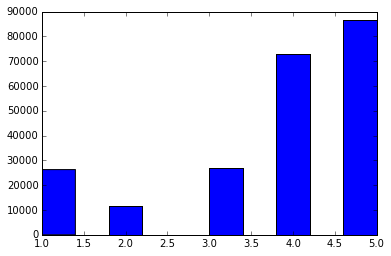

In [40]:
x = plt.hist(y_pred)

In [41]:
tadf.columns

Index([u'review_id', u'hotel_id', u'business_id', u'biz_review_id',
       u'biz_member_id', u'username', u'review_title', u'review_rating',
       u'review_text', u'review_date', u'review_category'],
      dtype='object')

In [42]:
tadf['dog_rating'] = y_pred

In [43]:
print(len(tadf))

224449


In [55]:
rat_1 = len(tadf[tadf['dog_rating'] == 1])
rat_2 = len(tadf[tadf['dog_rating'] == 2])
rat_3 = len(tadf[tadf['dog_rating'] == 3])
rat_4 = len(tadf[tadf['dog_rating'] == 4])
rat_5 = len(tadf[tadf['dog_rating'] == 5])
print(rat_1+rat_2+rat_3+rat_4+rat_5)
print(rat_1)
print(rat_2)
print(rat_3)
print(rat_4)
print(rat_5)

224449
26292
11617
26902
73051
86587


In [ ]:
tadf[tadf['dog_rating'] == 1]['business_id']

In [51]:
def update_table_rev_cat(df, engine, rating):
    brids = df[df['review_category'] == 'dog']['biz_review_id'].values
    sbrids = [str(brid) for brid in brids]
    cmd = 'UPDATE ta_reviews SET dog_rating = '+str(rating)+' '
    cmd += 'WHERE biz_review_id in ('+(',').join(sbrids)+')'

    conn = engine.connect()
    conn.execute(cmd)

In [54]:
for i in range(1, 6):
    print(i)
    catdf = tadf[tadf['dog_rating'] == i]
    update_table_rev_cat(catdf, engine, i)

1
2
3
4
5
